In [1]:
import hub
from PIL import Image
import numpy as np
import os, time
import torch #with fancy cuda
from torchvision import transforms, datasets, models
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import efficientnet_v2_m, efficientnet_v2_l, EfficientNet_V2_M_Weights, EfficientNet_V2_L_Weights
import matplotlib.pyplot as plt
import torch.optim as optim

C:\Users\Anthony\anaconda3\envs\ecs171\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.5.3) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
                                transforms.Resize((400, 400)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ColorJitter(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])
test_transform = transforms.Compose([
                                transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

train_data = datasets.ImageFolder('./car_data/car_data/train', train_transform)
test_data = datasets.ImageFolder('./car_data/car_data/test', test_transform)

In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ColorJitter(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])
test_transform = transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

train_data = datasets.ImageFolder('./car_data/car_data/train', train_transform)
test_data = datasets.ImageFolder('./car_data/car_data/test', test_transform)

In [3]:
classes = train_data.classes
class_idx = train_data.class_to_idx
len(class_idx)

196

In [4]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=1)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=1)

print(len(train_loader))

509


In [5]:
images, labels = next(iter(train_loader))
images.shape, len(labels)

(torch.Size([16, 3, 224, 224]), 16)

In [6]:
model = torch.load('./effnetLArch.pth')
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [6]:
model = models.efficientnet_v2_l(weights = EfficientNet_V2_L_Weights.DEFAULT)

classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(in_features=1280, out_features=196)
)

model.classifier = classifier

In [5]:
model = models.efficientnet_v2_m(weights = EfficientNet_V2_M_Weights.DEFAULT)

classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(in_features=1280, out_features=196)
)

model.classifier = classifier

In [14]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 196)

C:\Users\Anthony\anaconda3\envs\ecs171\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Anthony\anaconda3\envs\ecs171\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.required_grad = False
print(model.classifier)

classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=196),
    nn.LogSoftmax(dim=1)
)
model.classifier = classifier
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=196, bias=True)
  (7): LogSoftmax(dim=1)
)

In [10]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
for param in model.parameters():
    param.required_grad = False

classifier = nn.Sequential(
  nn.Linear(in_features=2048, out_features=1024),
  nn.LeakyReLU(),
  nn.Dropout(p=0.2),
  nn.Linear(in_features=1024, out_features=512),
  nn.LeakyReLU(),
  nn.Dropout(p=0.3),
  nn.Linear(in_features=512, out_features=196),
  nn.LogSoftmax(dim=1)  
)
    
model.fc = classifier
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=512, out_features=196, bias=True)
  (7): LogSoftmax(dim=1)
)

In [57]:
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.required_grad = False
print(model.classifier)

classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=196),
    nn.LogSoftmax(dim=1)
)
model.classifier = classifier
model.load_state_dict(torch.load('model.pt', map_location = torch.device('cuda'))['model_state_dict'])

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


<All keys matched successfully>

In [7]:
learning_rate = 0.001

# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
#optimizer.load_state_dict(torch.load('model.pt', map_location = torch.device('cuda'))['optimizer_state_dict'])

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [8]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        begin = time.time()
        running_loss = 0.0
        correct = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-begin
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100*correct/len(train_data)
        print("Epoch %s: time: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        test_acc = eval_model(model)
        
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')

In [9]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def get_predictions(model):
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            images = images.to(device)
            outputs = model(images)
            predicted = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(predicted)
            labels = labels.data.cpu().numpy()
            y_true.extend(labels)
    return y_pred, y_true

In [10]:
train_model(model, loss_fn, optimizer, lrscheduler, n_epochs=30)

Epoch 1: time: 221 s, loss: 5.1797, acc: 2.4804
Accuracy of the network on the test images: 11 %
Epoch 2: time: 208 s, loss: 4.0203, acc: 16.5275
Accuracy of the network on the test images: 37 %
Epoch 3: time: 210 s, loss: 2.5281, acc: 42.4239
Accuracy of the network on the test images: 62 %
Epoch 4: time: 208 s, loss: 1.5101, acc: 64.3541
Accuracy of the network on the test images: 74 %
Epoch 5: time: 212 s, loss: 1.0095, acc: 75.6999
Accuracy of the network on the test images: 80 %
Epoch 6: time: 216 s, loss: 0.6979, acc: 83.1655
Accuracy of the network on the test images: 84 %
Epoch 7: time: 216 s, loss: 0.5068, acc: 87.5860
Accuracy of the network on the test images: 85 %
Epoch 8: time: 216 s, loss: 0.3926, acc: 90.8399
Accuracy of the network on the test images: 86 %
Epoch 9: time: 215 s, loss: 0.3017, acc: 93.3080
Accuracy of the network on the test images: 87 %
Epoch 10: time: 208 s, loss: 0.2887, acc: 93.7377
Accuracy of the network on the test images: 87 %
Epoch 11: time: 208 

In [10]:
print(eval_model(model))

Accuracy of the network on the test images: 88 %
88.30991170252456


In [31]:
y_pred, y_true = get_predictions(model)

In [36]:
y_pred[10:20]

[0, 0, 0, 0, 148, 0, 0, 0, 0, 0]

In [37]:
y_true[10:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [34]:
cf_matrix = confusion_matrix(y_true, y_pred)

<Axes: >

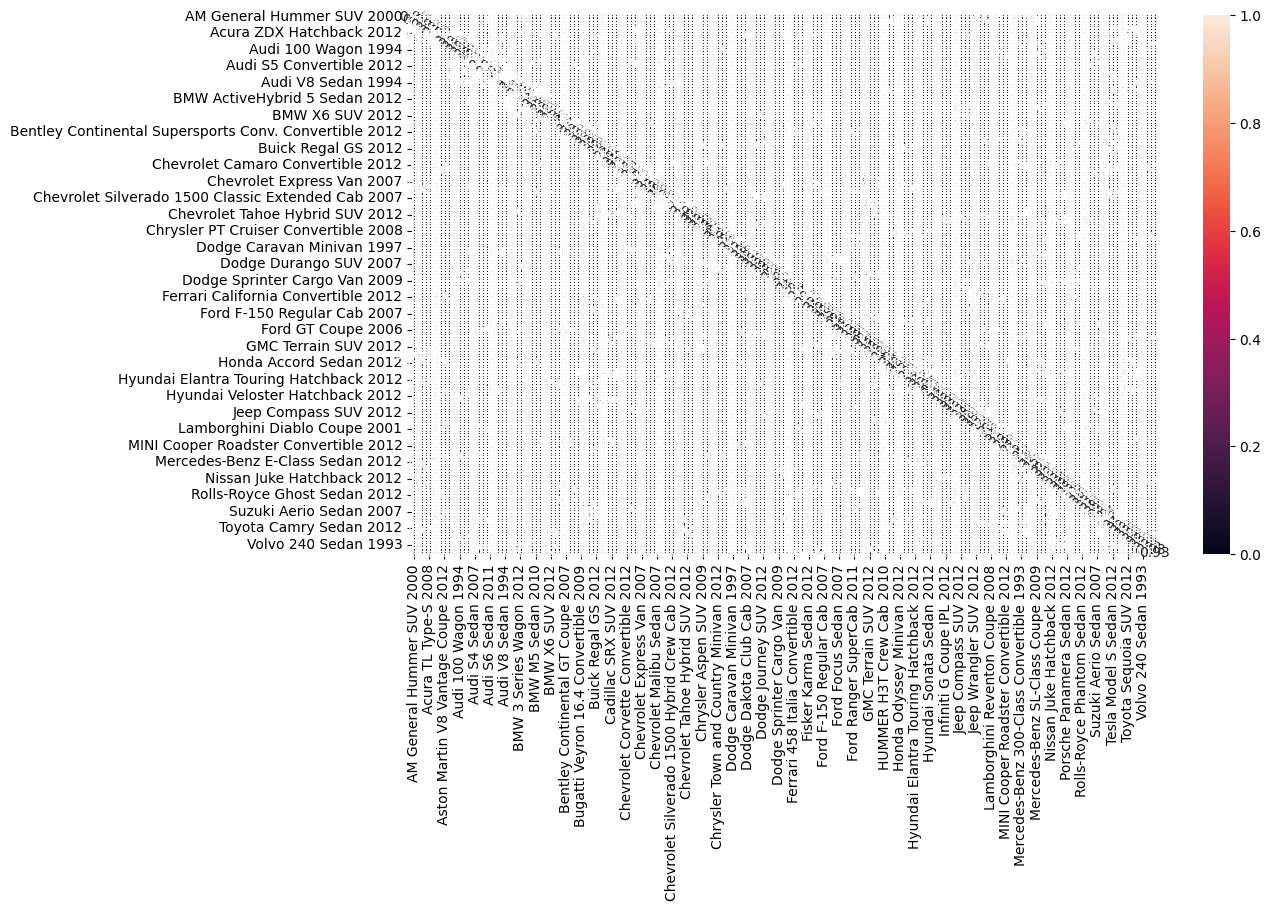

In [35]:
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [39]:
from sklearn.metrics import classification_report

print(classification_report(y_true,y_pred,target_names=classes))

                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.95      0.95      0.95        44
                             Acura Integra Type R 2001       0.89      0.93      0.91        44
                                   Acura RL Sedan 2012       0.62      0.75      0.68        32
                                   Acura TL Sedan 2012       0.83      0.93      0.88        43
                                  Acura TL Type-S 2008       0.91      0.95      0.93        42
                                  Acura TSX Sedan 2012       0.97      0.78      0.86        40
                              Acura ZDX Hatchback 2012       0.90      0.92      0.91        39
              Aston Martin V8 Vantage Convertible 2012       0.78      0.56      0.65        45
                    Aston Martin V8 Vantage Coupe 2012       0.78      0.76      0.77        41
                  Aston Martin Virage C

In [12]:
torch.save(model.state_dict(), "./effnetL.pt")

In [13]:
torch.save(model, "./effnetLArch.pth")